In [89]:
import sys

sys.path.append("../")

In [90]:
import scripts
import os

leaks_path = "../data/leaks"
reports_path = "../data/reports"
network_path = "../data/Hanoi.inp"

os.environ["EPANET_HOME"] = "../EPANET/build/bin/runepanet"

scripts.prepare_files(network_path, leaks_path)
scripts.run_simulations(leaks_path, reports_path)

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Hanoi.inp loaded successfully.

generating 32 input files...

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                               
... EPANET ran successfully.

... Running EPANET Version 2.3.0
                                                       

In [91]:
import pandas as pd

def extract_node_id(path: str) -> int:
    normpath = os.path.normpath(path)
    filename = normpath.split("/")[-1]
    return int(filename.split("_")[0])

In [92]:
report_dir_path = "../data/reports"
filenames = os.listdir(report_dir_path)

report_paths = [os.path.join(report_dir_path, filename) for filename in filenames if not filename.startswith("baseline")]
reports = [(scripts.read_report(path), extract_node_id(path)) for path in report_paths]

baseline_report = scripts.read_report(os.path.join(report_dir_path, "baseline_1.rpt"))

In [93]:
for i in range(1, len(baseline_report)):
    print((baseline_report[i-1] == baseline_report[i]).all())

pressure    True
dtype: bool
pressure    True
dtype: bool
pressure    True
dtype: bool


In [94]:
def report_to_pandas(report: list[pd.DataFrame], leakage_node: int) -> pd.DataFrame:

    training_example = []
    for i, pressure_measure in enumerate(report):
        pressure_measure = pressure_measure.T.reset_index(drop=True)
        pressure_measure.columns.name = None

        pressure_measure["ts"] = i
        pressure_measure["leakage_node"] = leakage_node

        training_example.append(pressure_measure)

    row_df = pd.concat(training_example)
    return row_df


def transform_whole_dataset(reports: list[tuple[list[pd.DataFrame], int]]) -> pd.DataFrame:
    report_dfs = []

    for report in reports:
        report_dfs.append(report_to_pandas(*report))

    df = pd.concat(report_dfs).reset_index(drop=True)
    return df

In [95]:
df = transform_whole_dataset(reports)
baseline_pressures = report_to_pandas(baseline_report, -1)

baseline_pressures = baseline_pressures.iloc[[0]].drop(columns=["ts", "leakage_node"]).to_numpy()
ts, leakage_node = df["ts"], df["leakage_node"]
pressures = df.drop(columns=["ts", "leakage_node"]).to_numpy()

pressures = pressures - baseline_pressures

In [96]:
from epyt import epanet

input_file = "../data/Hanoi.inp"
G = epanet(input_file)

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Hanoi.inp loaded successfully.



In [97]:
import numba
import numpy as np

@numba.jit(nopython=True)
def triple_loop(dist: np.ndarray, n: int) -> np.ndarray:
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    return dist


def floyd_warshall(adj_matrix: np.ndarray, undirected: bool = True) -> np.ndarray:
    n = adj_matrix.shape[0]
    if undirected:
        adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
        
    dist = np.full_like(adj_matrix, float(n + 1))
    dist[adj_matrix > 0] = 1.0
    np.fill_diagonal(dist, 0.0)

    dist = triple_loop(dist, n)
    return dist


def matrix_to_adj_list(matrix: np.ndarray, undirected: bool = True) -> list[set[int]]:
    n = matrix.shape[0]
    if undirected:
        matrix = np.maximum(matrix, matrix.T)

    adj_list = [set() for _ in range(n)]
    for i, row in enumerate(matrix):
        for neighbor, connected in enumerate(row):
            if connected > 0:
                adj_list[i].add(neighbor)
                adj_list[neighbor].add(i)

    return adj_list


class Network:
    def __init__(self, G: epanet):
        self.G = G

        self.adj_matrix = G.getAdjacencyMatrix()
        self.adj_list = matrix_to_adj_list(self.adj_matrix, undirected=True)
        self.distances = floyd_warshall(self.adj_matrix, undirected=True)

        self.node_ids = G.NodeNameID
        self.node_indexes = list(map(lambda x: x - 1, G.NodeIndex))
        self.node_id_to_position_mapping = dict(zip(G.NodeNameID, self.node_indexes))

    def plot_with_ids(self):
        self.G.plot(nodesID=self.node_ids, fontsize=3)

    def plot_with_indexes(self):
        self.G.plot(nodesindex=list(map(lambda x: x + 1, self.node_indexes)), fontsize=3)


    def map_node_ids(self, ids: np.ndarray) -> np.ndarray:
        ids = list(map(str, ids))
        return np.array(list(map(self.node_id_to_position_mapping.get, ids)))


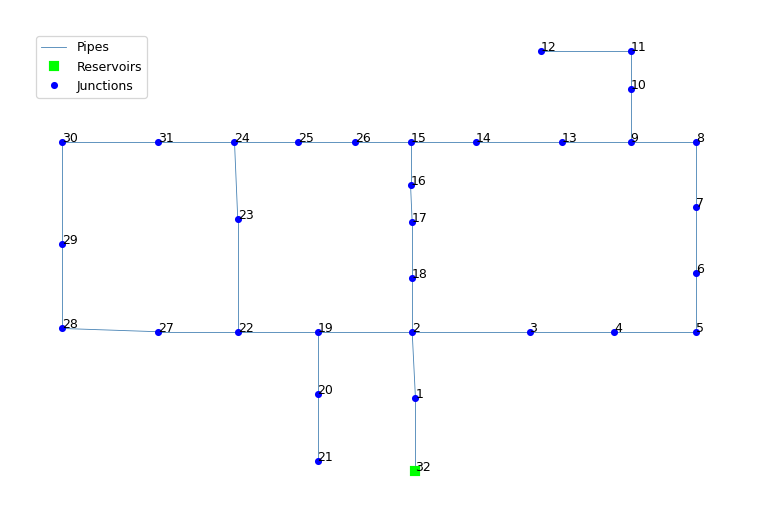

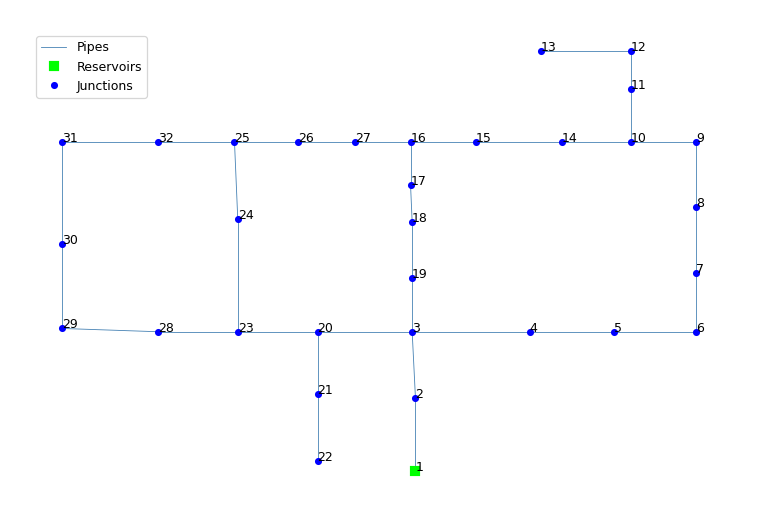

In [98]:
network = Network(G)
network.plot_with_indexes()
network.plot_with_ids()

In [99]:
def random_solution(vertices: np.ndarray, m: int) -> np.ndarray:
    return np.random.permutation(vertices)[:m]


vertices = np.array(network.node_indexes)
solution = random_solution(vertices, 3)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

leakage_node_mapped = network.map_node_ids(leakage_node)
train_pressure, test_pressures, train_labels, test_labels = train_test_split(pressures, leakage_node_mapped, test_size=0.5)

In [161]:
def evaluate_solution(
        vertices_subset: np.ndarray, 
        network: Network,
        train_pressure: np.ndarray,
        train_labels: np.ndarray,
        test_pressures: np.ndarray,
        test_labels: np.ndarray,
        d_max: float = 3
    ) -> float:

    train_subset = train_pressure[:, vertices_subset]
    test_subset = test_pressures[:, vertices_subset]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_subset, train_labels)

    pred_label = knn.predict(test_subset)

    dists = network.distances[pred_label, test_labels] / d_max
    dists[dists >= 1.0] = 1.0 
    loss = dists.sum() / pred_label.shape[0]

    return loss

In [192]:
solution = random_solution(vertices, 1)
solution

array([10])

In [193]:
evaluate_solution(solution, network, train_pressure, train_labels, test_pressures, test_labels)

np.float64(0.6899224806201549)